In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import randn, seed
from scipy.optimize import minimize
import sys

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
port_path = "Prueba.xlsx"
market = pd.read_excel(port_path, index_col=0)
market.columns = [c.replace(" MF Equity", "").replace(" INDEX", "") for c in market.columns]

In [5]:
market.head()

,KIMBERA,GAPB,CEMEXCPO,ASURB,GFNORTEO,KOFUBL,AC*,LABB,FEMSAUBD,OMAB,...,MEGACPO,GCC*,BIMBOA,GMEXICOB,GCARSOA1,TLEVICPO,ALFAA,BSMXB,PINFRA*,MEXBOL
DATE,,,,,,,,,,,,,,,,,,,,,
2016-01-01,40.37,152.05,8.72,243.89,94.99,123.90,104.68,13.85,161.63,83.61,...,64.19,44.81,45.95,36.79,70.98,94.34,34.10,30.25,202.73,42977.50
2016-01-04,39.16,148.57,8.43,238.29,91.79,120.29,102.09,14.41,157.62,81.77,...,64.45,43.51,45.02,35.71,69.83,92.62,33.74,29.46,202.93,42113.70
2016-01-05,38.89,147.93,8.31,233.03,91.72,118.82,101.12,13.77,157.80,81.58,...,63.16,43.51,45.77,36.45,70.70,91.89,33.99,29.72,203.56,42041.68
2016-01-06,39.13,146.99,8.29,231.97,91.63,120.32,102.50,13.65,156.37,82.03,...,63.27,43.51,45.97,35.57,70.47,90.41,33.65,29.67,199.80,41691.19
2016-01-07,39.16,141.32,7.64,230.71,89.54,120.20,101.16,13.25,155.14,80.94,...,62.78,42.76,46.18,35.01,68.15,90.23,31.46,28.50,196.75,40661.57


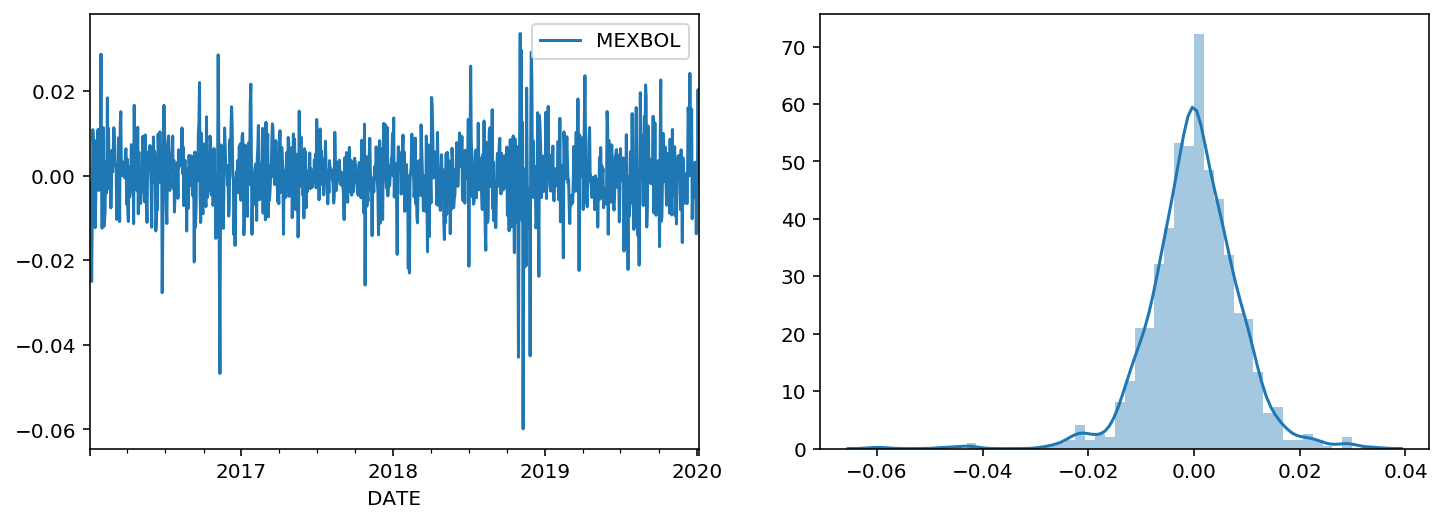

In [7]:
R = market[["MEXBOL"]]
R = np.log(R).diff().dropna()
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
R.plot(ax = ax[0])
sns.distplot(R, ax=ax[1]);

In [8]:
test_year = "2019"
R_train = R[:test_year]
R_test = R[test_year:]

## GARCH

$$
    \sigma_t^2 = \omega + \alpha r^2_{t-1} + \beta\sigma^2_{t-1}
$$

## Modelo de volatilidad dinámica

$$
    \sigma_t^2 = (1-\lambda)r^2_{t-1} + \lambda \sigma^2_{t-1}
$$

para efectos del código llamaremos $\alpha = (1-\lambda)$.

Verosimilitud
$$
    \log L = \sum_{t=1}^T\left(\log \sigma_t^2 + \frac{r_t^2}{\sigma_t^2}\right)
$$

In [19]:
class GARCHSigmas:
    """
    Clase para estimar sigmas para un GARCH(1, 1)
    """
    def __init__(self, alpha, lambda_, sigma_init, R):
        self.alpha = alpha
        self.lambda_ = lambda_
        self.R = R
        self.sigma_hist = [sigma_init]
        self.initialize_sigmas()
        
    def get_sigma1(self, t):
        """
        Calcula sigma_t dado datos en t-1
        """
        rt0 = 0 if t==0 else self.R.iloc[ t - 1, 0]
        sigma0 = self.sigma_hist[-1]
        sigma1 = self.alpha * rt0 ** 2 + self.lambda_ * sigma0
        self.sigma_hist.append(sigma1)
        
    def initialize_sigmas(self):
        N, M = self.R.shape
        for t in range(N-1, -1, -1):
            self.get_sigma1(t)

In [20]:
def LGarch(alpha, lambda_, sigma_init, R):
    s = GARCHSigmas(alpha, lambda_, sigma_init, R)
    sigma_hist = np.array(s.sigma_hist[1:])
    r1_2 = R.values.ravel() ** 2
    log_likelihood = (np.log(sigma_hist) + r1_2 / sigma_hist).sum() / 2
    return log_likelihood

In [23]:
seed(314)
lambda_ = np.abs(randn(1))
alpha = (1-lambda_)
sigma_init = R.var(ddof=1).item() / 252
LGarch(alpha, lambda_, sigma_init, R)

-551705.0600243221

In [46]:
# Configuración del modelo
x0 = np.array([alpha, lambda_])
L_part = lambda x0: LGarch(*x0, sigma_init, R)

def cons(x):
    return x[0] + x[1] - 1

# Restricción de no negativos
bounds = [
    (0, None),
    (0, None)
]

In [47]:
fmin = minimize(L_part, x0, constraints={"type": "ineq", "fun": cons}, bounds=bounds)

e:\Users\fgarciaro\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars


In [48]:
fmin

     fun: -4401.992892514292
     jac: array([0.01245117, 0.02111816])
 message: 'Optimization terminated successfully.'
    nfev: 71
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([0.18613121, 0.87645973])

In [49]:
alpha_garch, lambda_garch = fmin.x

In [50]:
# Sirve para estimar volatilidades (Volatilidades sigma2)
sigma0 = sigma_init
garch_predict = []
for i in range(len(R)):
    sigma0 = alpha_garch * R.iloc[i].item()**2 + lambda_garch * sigma0
    garch_predict.append(sigma0)

In [51]:
garch_predict

[7.697739378809419e-05,
 6.801286890317887e-05,
 7.26555257391853e-05,
 0.0001800713609118047,
 0.00017567080183234304,
 0.00017610524544816065,
 0.0001654686809538985,
 0.00014504819791334543,
 0.00014011493978864314,
 0.00015091184344352134,
 0.00013888976754369945,
 0.0001264269753986348,
 0.00011094619969585789,
 0.00010875092872802892,
 0.0001177486951456566,
 0.00010546767136908867,
 0.00011469537100272668,
 0.00010384697118098655,
 9.937585276828986e-05,
 0.00024125757238832688,
 0.00021145254749478003,
 0.00021401337482680272,
 0.0001902942144898634,
 0.00019082302395230283,
 0.00019409029534280783,
 0.00019093439588752762,
 0.0001818293667356166,
 0.0001612904975799932,
 0.00014458204242058875,
 0.00012705904584307194,
 0.00017466171151125085,
 0.0001541983565692428,
 0.0001584465688092212,
 0.00013933345326239883,
 0.00012409037026494464,
 0.0001116555084060726,
 0.00010864127904037664,
 9.540287495538349e-05,
 9.036897020583691e-05,
 7.935331314407356e-05,
 7.526496794950849

In [52]:
%matplotlib inline

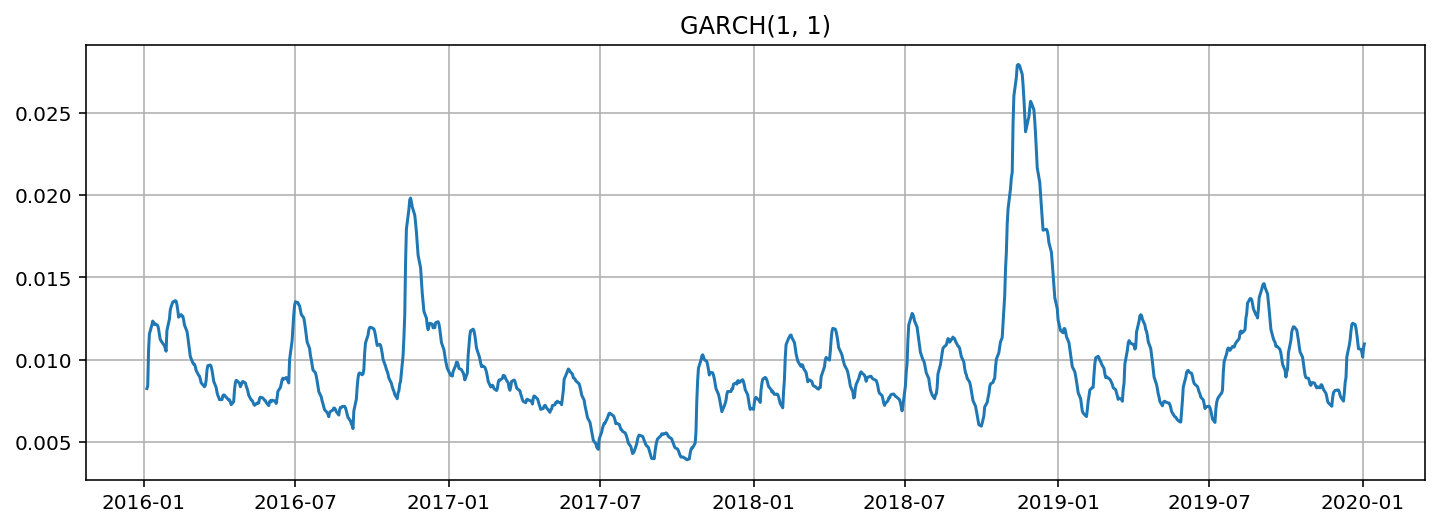

In [53]:
# Estimaciones de GARCH a tiempo t+1
xaxis = R.index[1:]
sigma_garch = pd.Series(np.sqrt(garch_predict)[1:])

plt.subplots(figsize=(12, 4))
plt.title("GARCH(1, 1)")
plt.grid()
#plt.plot(xaxis, sigma_garch);
plt.plot(xaxis, sigma_garch.ewm(3).mean()); # Media exponencial de 3 periodos para suavizar la gráfica